# We first import libraries

In [1]:
import numpy as np 
import math 
import pandas as pd 
pd.set_option('display.float_format',lambda x:'%.3f' % x)
import matplotlib.pyplot as plt 
plt.style.use('ggplot')
%matplotlib inline
import seaborn as sns 
sns.set_palette('muted')
sns.set_style('darkgrid')
import warnings
warnings.filterwarnings('ignore')
import os 
from tqdm import tqdm

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

import lightgbm as lgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
import optuna

np.random.seed(2021)

# 1. we load the dataset

In [2]:
data= pd.read_csv('xn--CDCs_Social_Vulnerability_Index_(SVI)__2014_overall_SVI,_census_tract_level_-_Wake_County-7470duo.csv',encoding='gb18030')
print(data.shape)
data.describe()

(72842, 129)


,锘縁ID,TRACTCE,ST,STCNTY,FIPS,AREA_SQMI,E_TOTPOP,M_TOTPOP,E_HU,M_HU,...,F_GROUPQ,F_THEME4,F_TOTAL,E_UNINSUR,M_UNINSUR,EP_UNINSUR,MP_UNINSUR,E_DAYPOP,SHAPE_Length,SHAPE_Area
count,72842.000,72842.000,72842.000,72842.000,72842.000,72842.000,72842.000,72842.000,72842.000,72842.000,...,72842.000,72842.000,72842.000,72842.000,72842.000,72842.000,72842.000,72842.000,72842.000,72842.000
mean,36421.500,256511.031,27.743,27828.739,27828995480.307,48.488,4312.170,370.190,1822.315,80.848,...,0.100,-5.042,-4.818,602.374,210.333,14.154,-2.197,4308.218,0.322,0.015
std,21027.818,347887.689,15.789,15813.197,15813202911.480,542.521,2074.882,189.366,849.374,47.110,...,0.300,74.234,79.283,513.036,135.047,9.041,84.105,4365.750,0.876,0.276
min,1.000,100.000,1.000,1001.000,1001020100.000,0.000,0.000,0.000,0.000,2.000,...,0.000,-999.000,-999.000,0.000,2.000,0.000,-999.000,-999.000,0.000,0.000
25%,18211.250,10300.000,12.000,12127.000,12127082704.250,0.692,2894.000,244.000,1256.000,48.000,...,0.000,0.000,0.000,258.000,114.000,7.500,3.200,2078.000,0.064,0.000
50%,36421.500,44000.000,27.000,27129.000,27129790450.000,1.885,4048.000,342.000,1717.000,71.000,...,0.000,0.000,1.000,461.000,181.000,12.500,4.600,3297.000,0.113,0.001
75%,54631.750,461775.750,41.000,41039.000,41039000275.000,13.256,5410.750,468.000,2273.000,103.000,...,0.000,1.000,2.000,791.000,275.000,19.000,6.000,5213.000,0.323,0.004
max,72842.000,992201.000,56.000,56045.000,56045951300.000,85425.847,46330.000,3365.000,24087.000,911.000,...,1.000,4.000,13.000,7794.000,1705.000,100.000,100.000,245684.000,71.927,50.971


# 2. We first explore this dataset
we found that some types have nulls values (-999) and we generally print their stats

In [3]:
data.RPL_THEMES.value_counts()
null_value=[]
def statics(data):
    for col in data.columns:
        null_value.append([col,np.sum(data[col]==-999),data[col].dtypes,len(data[col].unique())])
statics(data)
null_value=pd.DataFrame(null_value,columns=['column_name','number_of_null_value','Data_type','Unique'])
null_value=null_value.sort_values(by='number_of_null_value',ascending=False)  
null_value.head(20) 

,column_name,number_of_null_value,Data_type,Unique
52,MP_PCI,1076,int64,10638
22,M_PCI,1076,int64,10638
74,MP_NOVEH,603,float64,350
62,MP_SNGPNT,603,float64,366
72,MP_CROWD,603,float64,339
70,MP_MOBILE,583,float64,339
68,MP_MUNIT,583,float64,366
48,MP_POV,551,float64,386
50,MP_UNEMP,530,float64,334
125,MP_UNINSUR,514,float64,329


Percentage of null values
for example there are 2 classes which have two null values

(array([96.,  0.,  0., 12., 13.,  6.,  0.,  0.,  0.,  2.]),
 array([0.        , 0.00147717, 0.00295434, 0.00443151, 0.00590868,
        0.00738585, 0.00886302, 0.01034019, 0.01181736, 0.01329453,
        0.0147717 ]),
 <BarContainer object of 10 artists>)

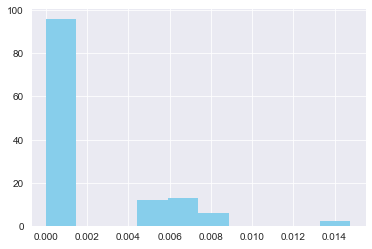

In [4]:
plt.hist(null_value.number_of_null_value/len(data),color = "skyblue", lw=0)

We found that some classes are objects.
And some classes like STATE and ST_ABBR are repretitive so we drop the repeated ones

In [5]:
data[data.columns[data.dtypes=="object"]].describe()

,AFFGEOID,STATE,ST_ABBR,COUNTY,LOCATION
count,72842,72842,72842,72842,72842
unique,72842,51,51,1850,72842
top,1400000US13063040524,California,CA,Los Angeles,"Census Tract 18.03, Minnehaha County, South Da..."
freq,1,8043,8043,2344,1


# 3. We perform some data cleaninng
We first drop contents that are repettive/similar and convert string values to int values so that the model can parse

In [6]:
data.drop(columns=["AFFGEOID","STATE","LOCATION"],inplace=True)
object_columns=data.columns[data.dtypes=="object"]
data=pd.get_dummies(data,columns=object_columns)

data.nunique().sort_values()[-50:]
for col in data.columns:
    data[col][data[col]==-999]=np.mean(data[col])
selected_data = data.copy()

We will require the target values to be in normal ranges (0~1)

In [7]:
data=data[data.RPL_THEMES>=0]

# 4. We train the model with lightgbm

Five models are trained on the same inputs, with different objectives to predict RPL_THEME1, RPL_THEME2, RPL_THEME3, RPL_THEME4, RPL_THEMES, which respectively represents Socioeconomic theme, Housing Composition and Disability, Minority Status & Language, Housing & Transportation rankings, and their overall ranking

In [8]:
%%capture
all_targets = ['RPL_THEME1', 'RPL_THEME2', 'RPL_THEME3', 'RPL_THEME4', 'RPL_THEMES']
all_targets_spl = ['SPL_THEME1', 'SPL_THEME2', 'SPL_THEME3', 'SPL_THEME4', 'SPL_THEMES']

param =   {
        'num_leaves': 50,
        'objective': 'rmse',  
        'max_depth': 10,
        'learning_rate': 7e-1,
        "boosting": "gbdt",
        'lambda_l1': 1e-6,
        'lambda_l2': 1e-2,
        'bagging_freq': 5,
        'bagging_fraction': 0.98,
        "feature_fraction": 0.8,
        "verbosity":-1,
    }
data_inputs=selected_data.copy()
data_inputs.drop(columns=all_targets,inplace=True)
data_inputs.drop(columns=all_targets_spl,inplace=True)
all_feature_imp = []
results_dict_v1 = []
split_data = []
for target in all_targets:  
    data_label=selected_data[target].values
    X_train,x_test,y_train,y_test=train_test_split(data_inputs, data_label, test_size=0.2)
    split_data.append([X_train,x_test,y_train,y_test])
    model = lgb.LGBMRegressor(**param)    
    model.fit(X_train,y_train,eval_set=[(x_test,y_test)], early_stopping_rounds=100, verbose=False, )
    preds = model.predict(x_test)
    rmse = mean_squared_error(y_test, preds, squared=False)
        
    all_feature_imp.append(model.feature_importances_)
    results_dict_v1.append([target, rmse])


# We show the model's performance on these different targets
### the performance is good and around 1-4 percent error (lower the better)

In [9]:
for item in results_dict_v1:
    print('rmse scores for target ', item[0], ' is ', (item[1]*100.0).round(3), '%')

rmse scores for target  RPL_THEME1  is  1.641 %
rmse scores for target  RPL_THEME2  is  2.987 %
rmse scores for target  RPL_THEME3  is  0.715 %
rmse scores for target  RPL_THEME4  is  3.197 %
rmse scores for target  RPL_THEMES  is  4.355 %


# 4.2 We visualize what features are important for the model prediction, then we filter out features that have low importance

In [110]:
THRESHOLD = 1 #this is the threshold of importance for filtering out
def getImp(feature_imp, data, num = 20, fig_size = (40, 20)):
    columns_imp = [item for item in data.columns if item not in ['RPL_THEME1', 'RPL_THEME2', 'RPL_THEME3', 'RPL_THEME4', 'RPL_THEMES', 'SPL_THEME1', 'SPL_THEME2', 'SPL_THEME3', 'SPL_THEME4', 'SPL_THEMES']]
    
    columns_imp = np.array(columns_imp)[feature_imp>THRESHOLD]
    feature_imp = feature_imp[feature_imp>THRESHOLD]
    feature_imp = pd.DataFrame(sorted(zip(feature_imp, columns_imp)), columns=['Value','Feature'])

    return feature_imp, columns_imp

In [111]:
plots = []
all_useful_columns = []
for feature_imp in all_feature_imp:
    feature_imp, columns_imp = getImp(model.feature_importances_, data)
    plots.append(feature_imp)
    all_useful_columns.append(columns_imp)

feature importance for RPL_THEME1


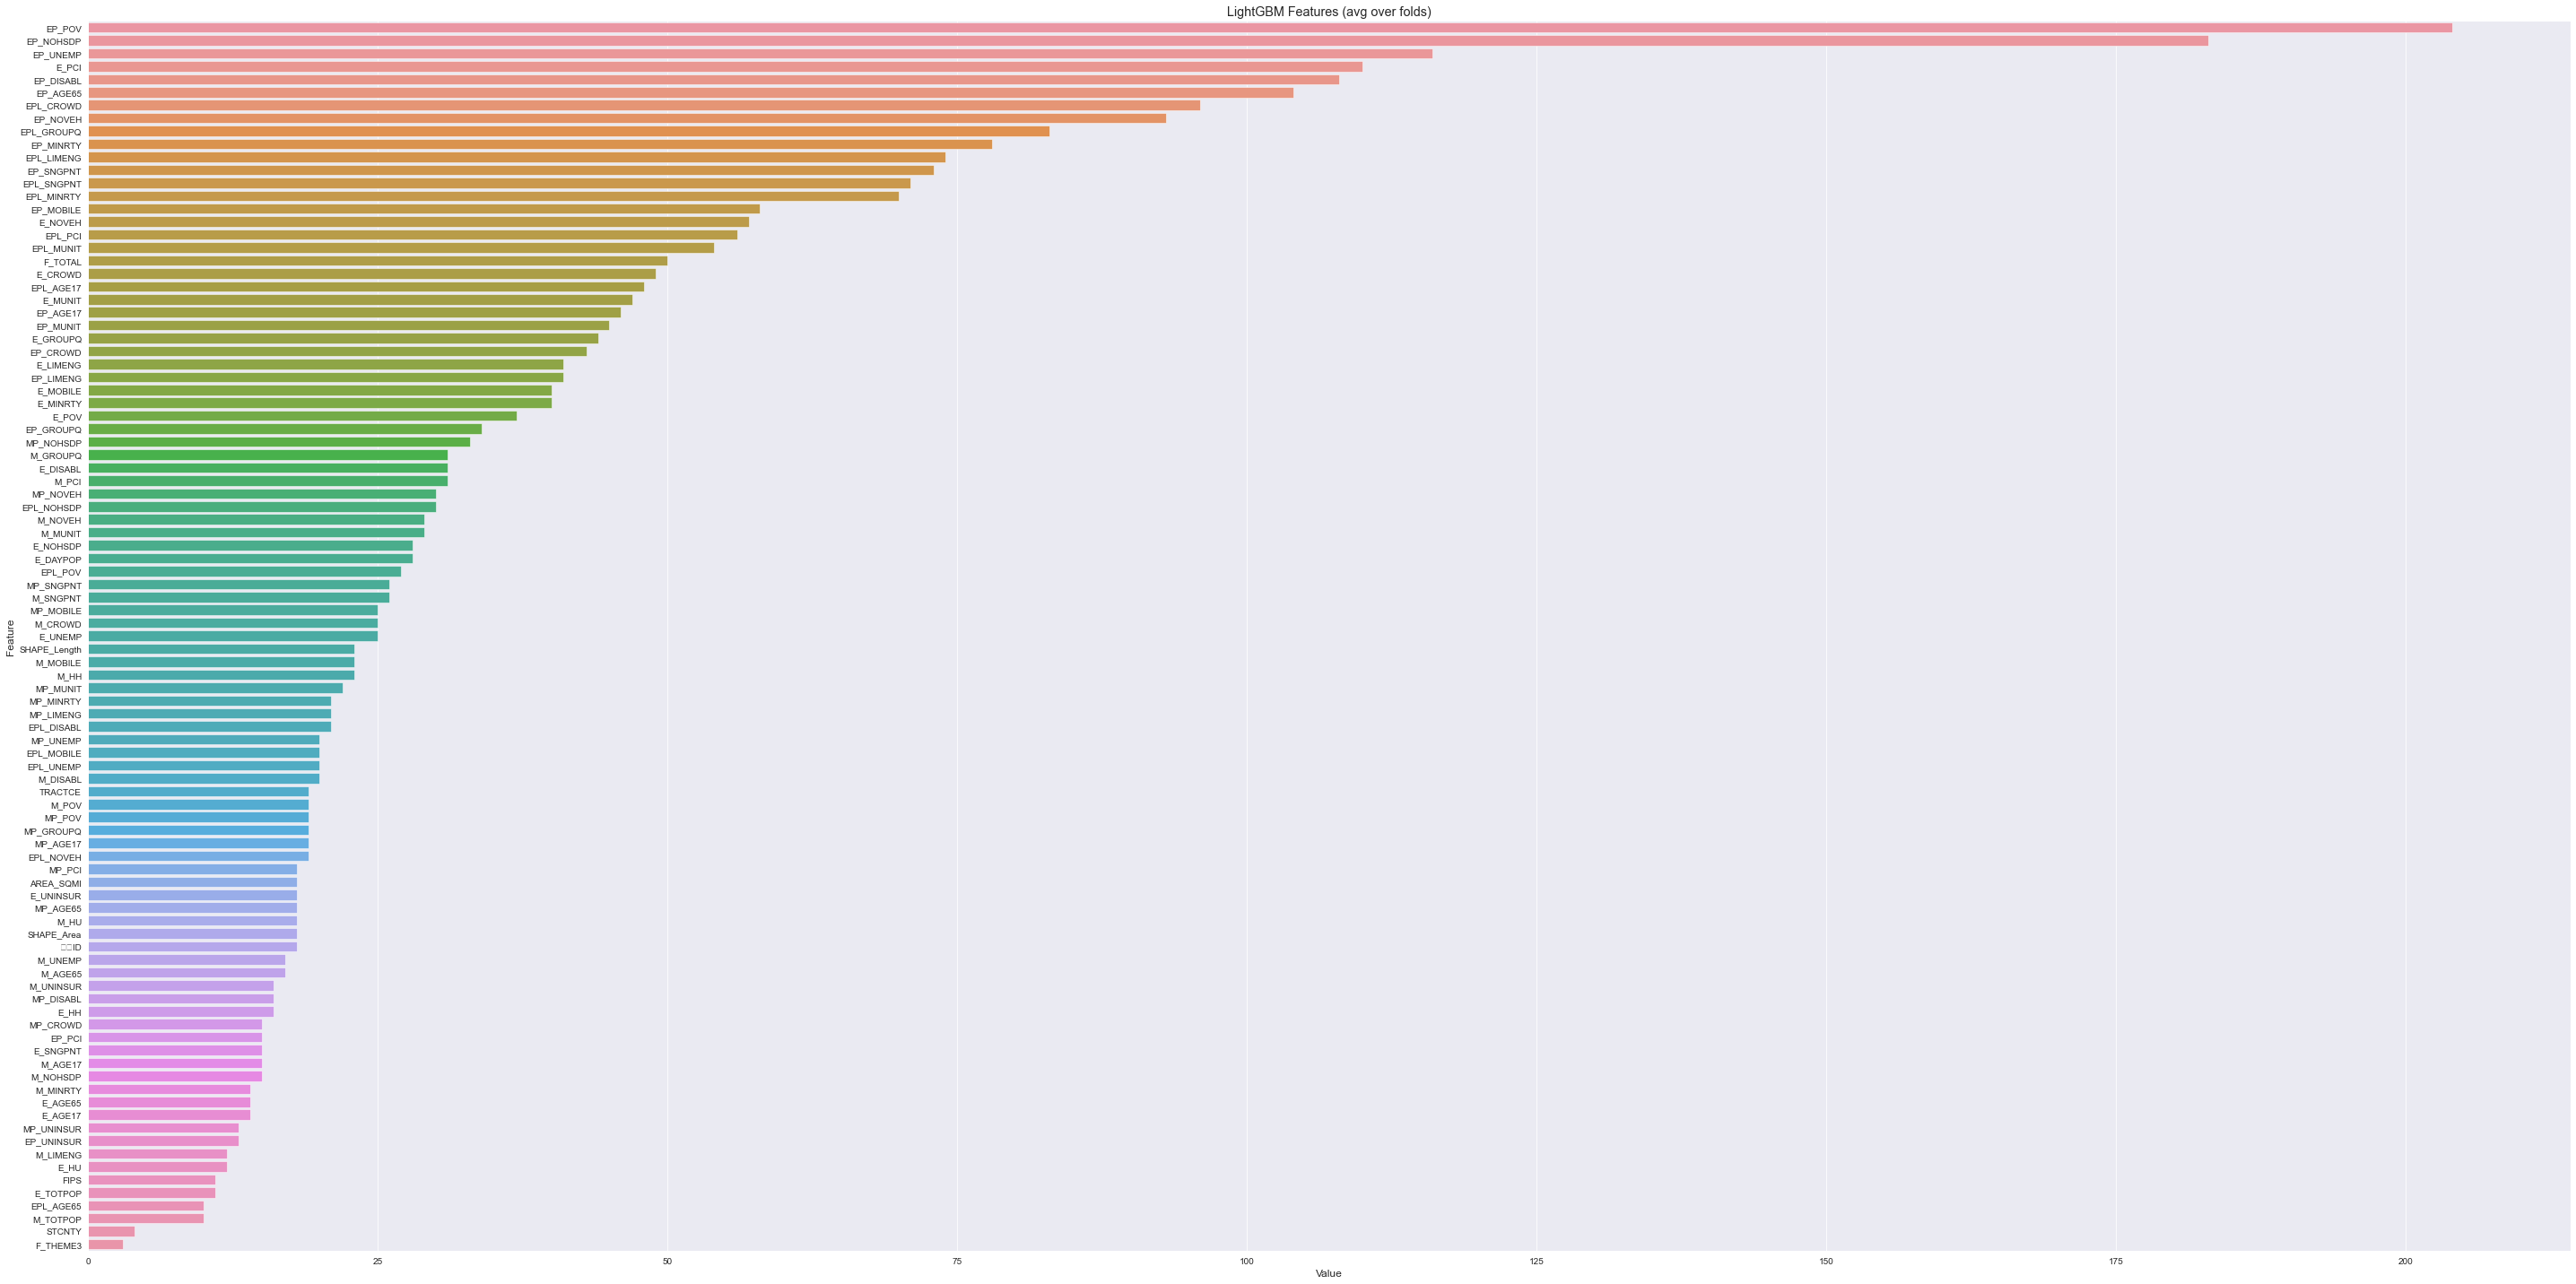

feature importance for RPL_THEME2


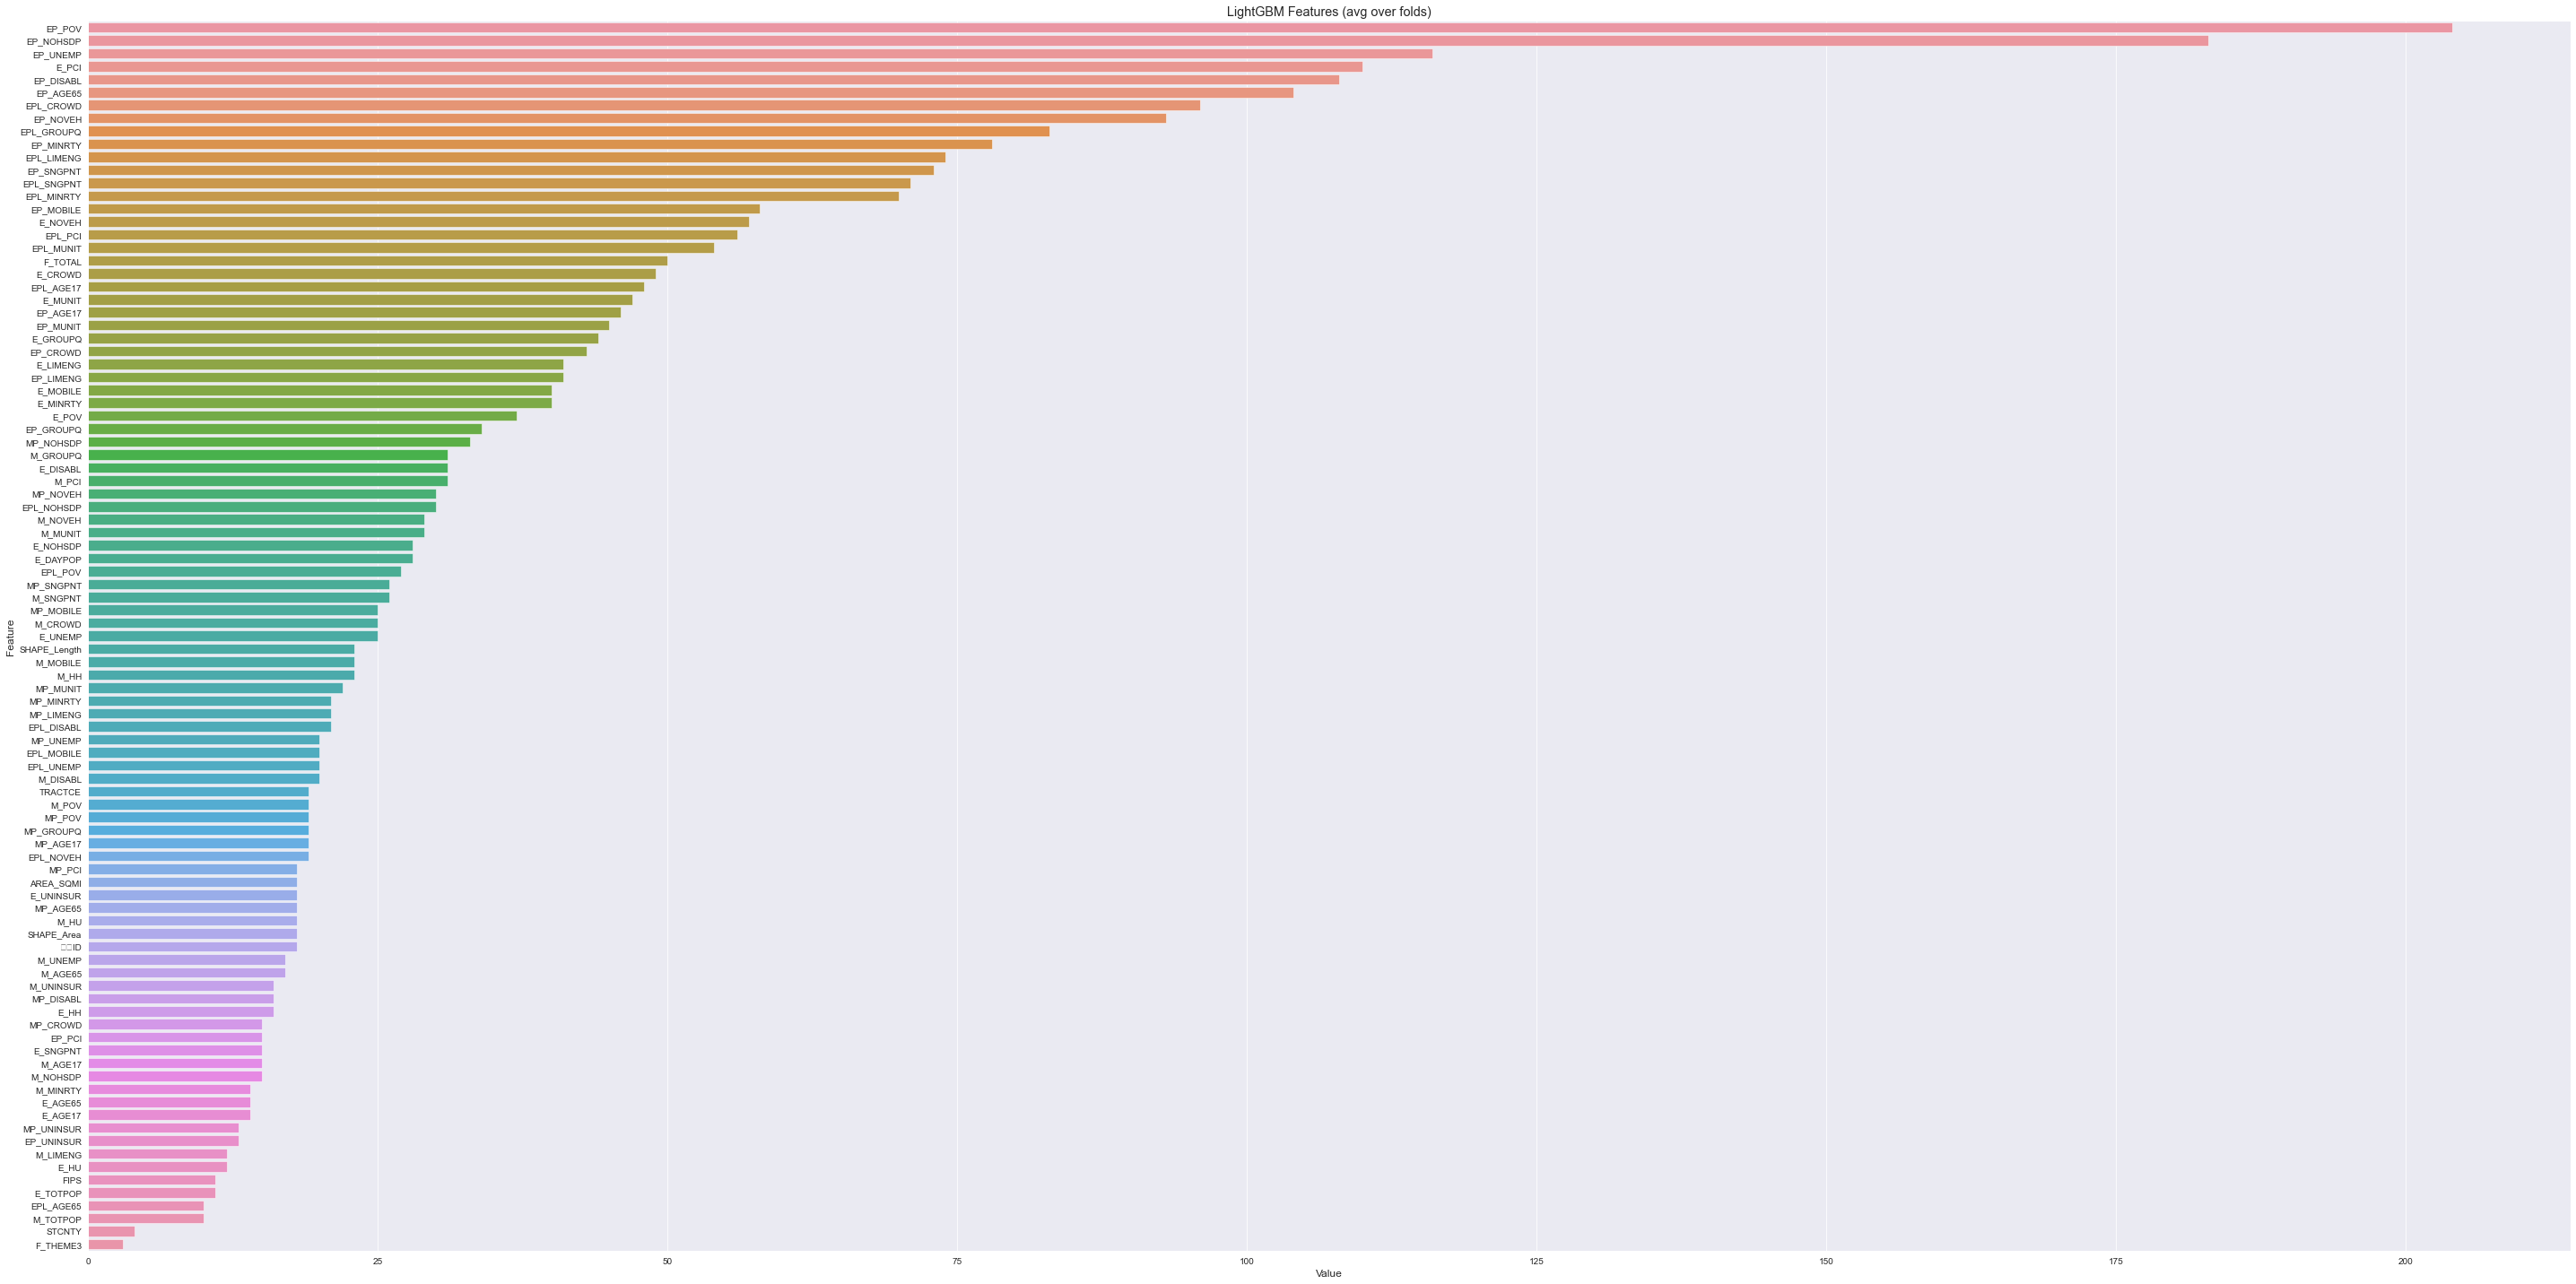

feature importance for RPL_THEME3


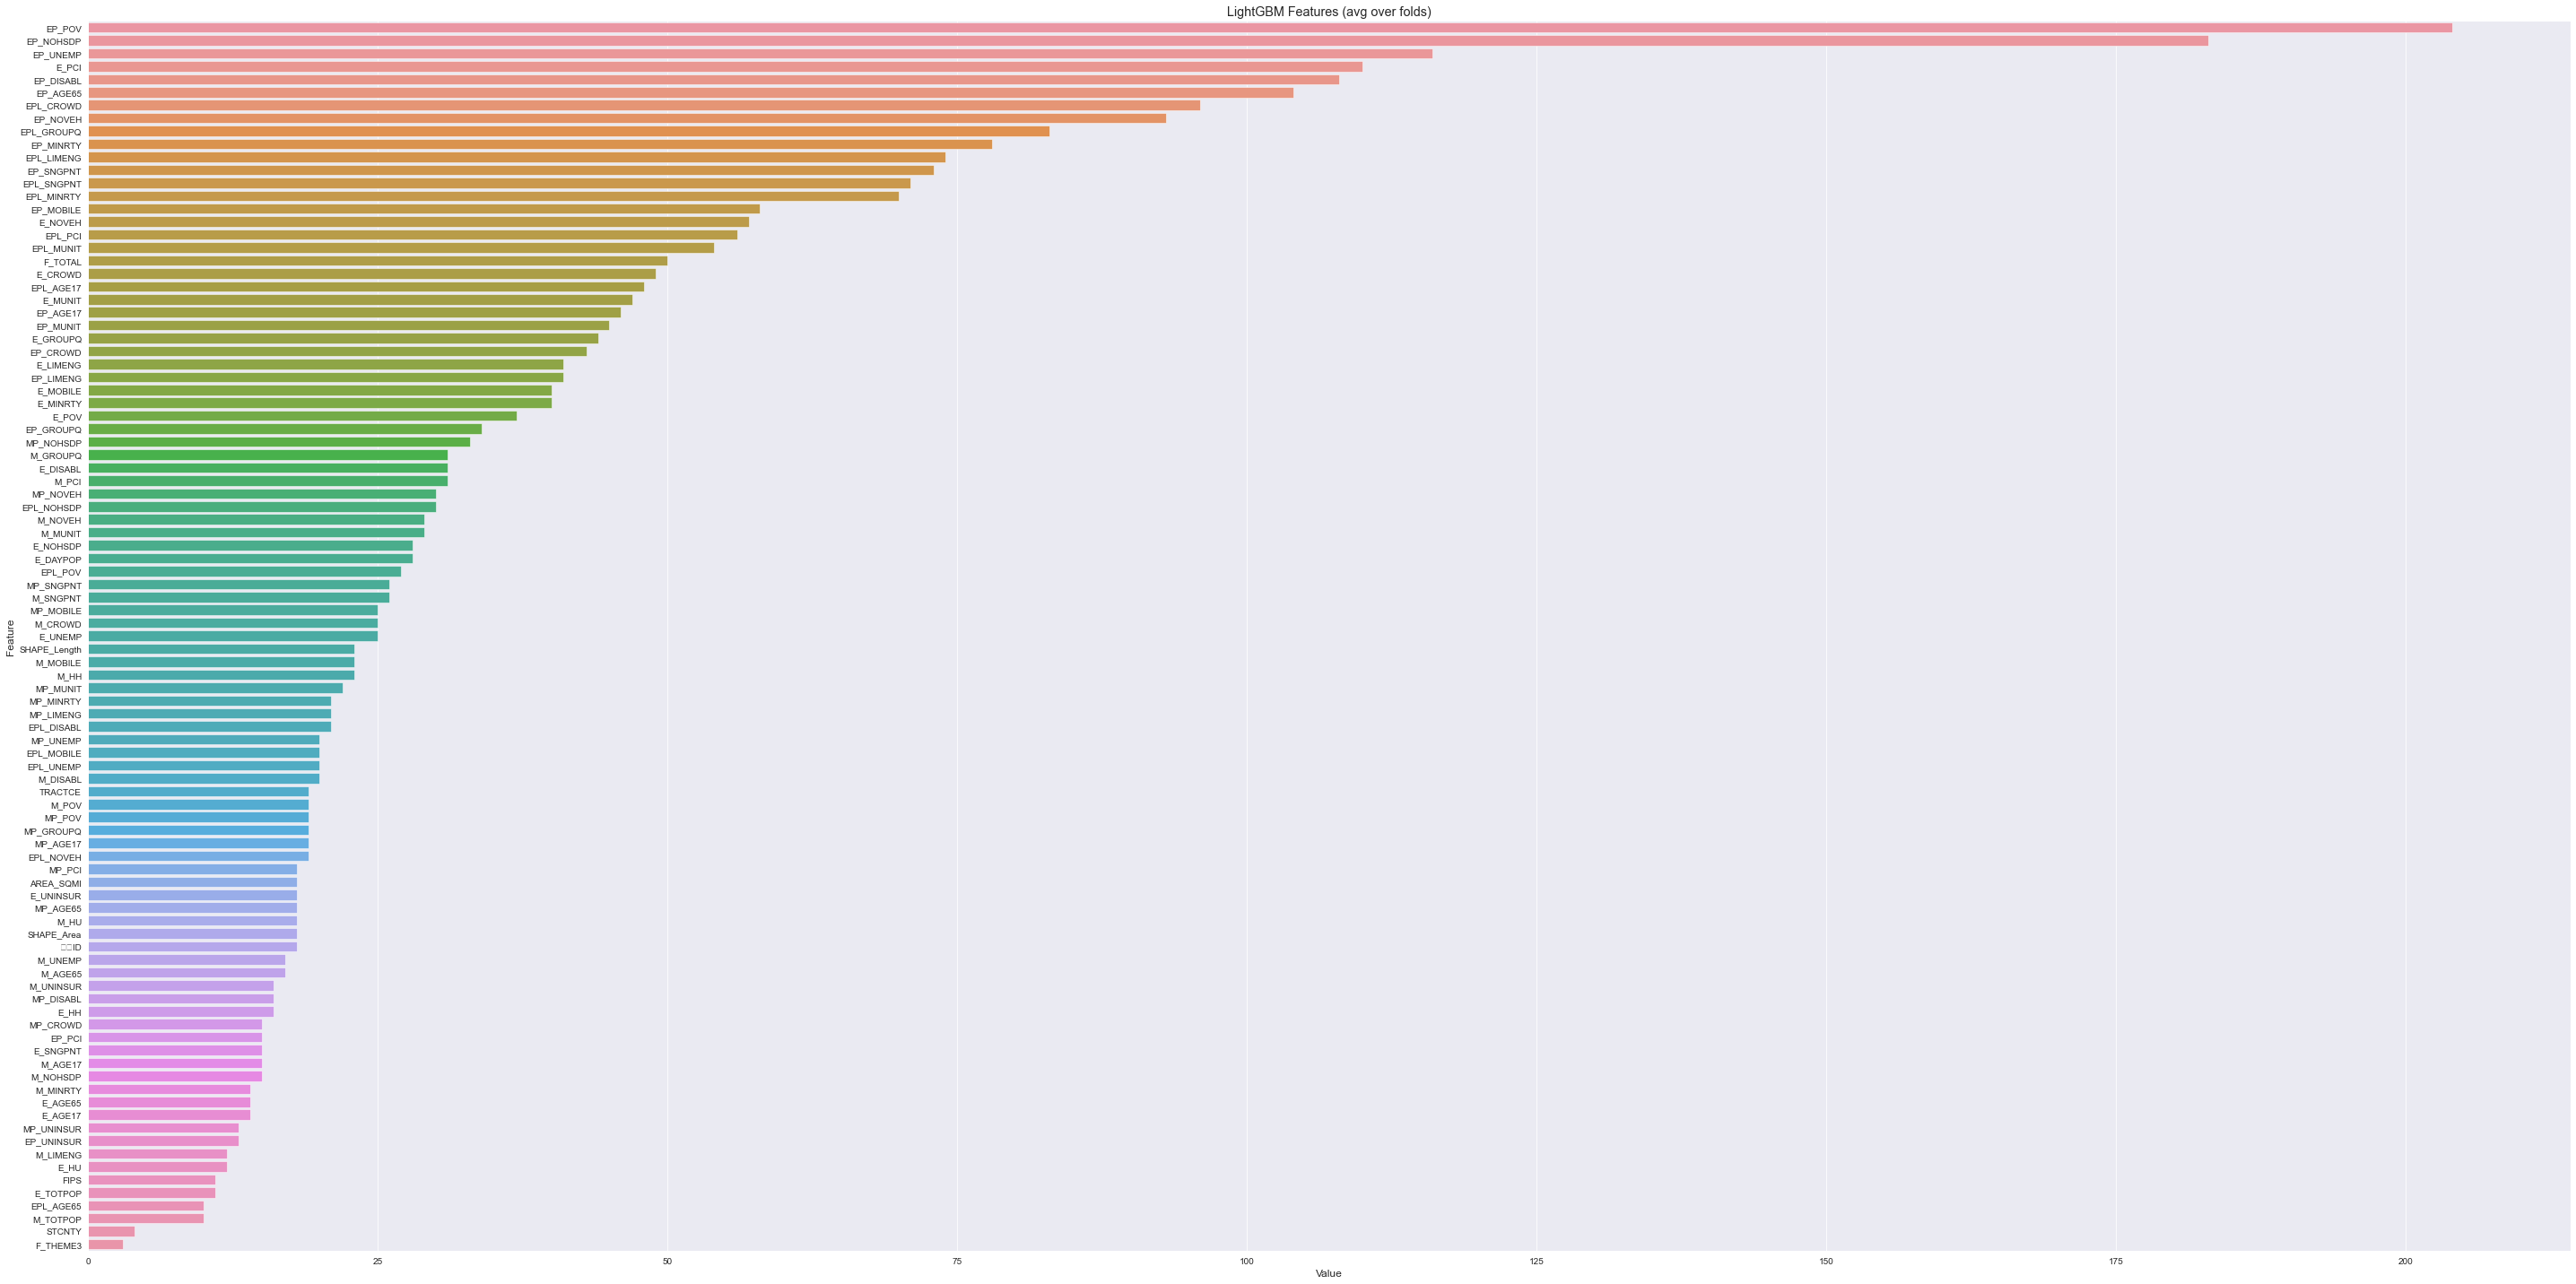

feature importance for RPL_THEME4


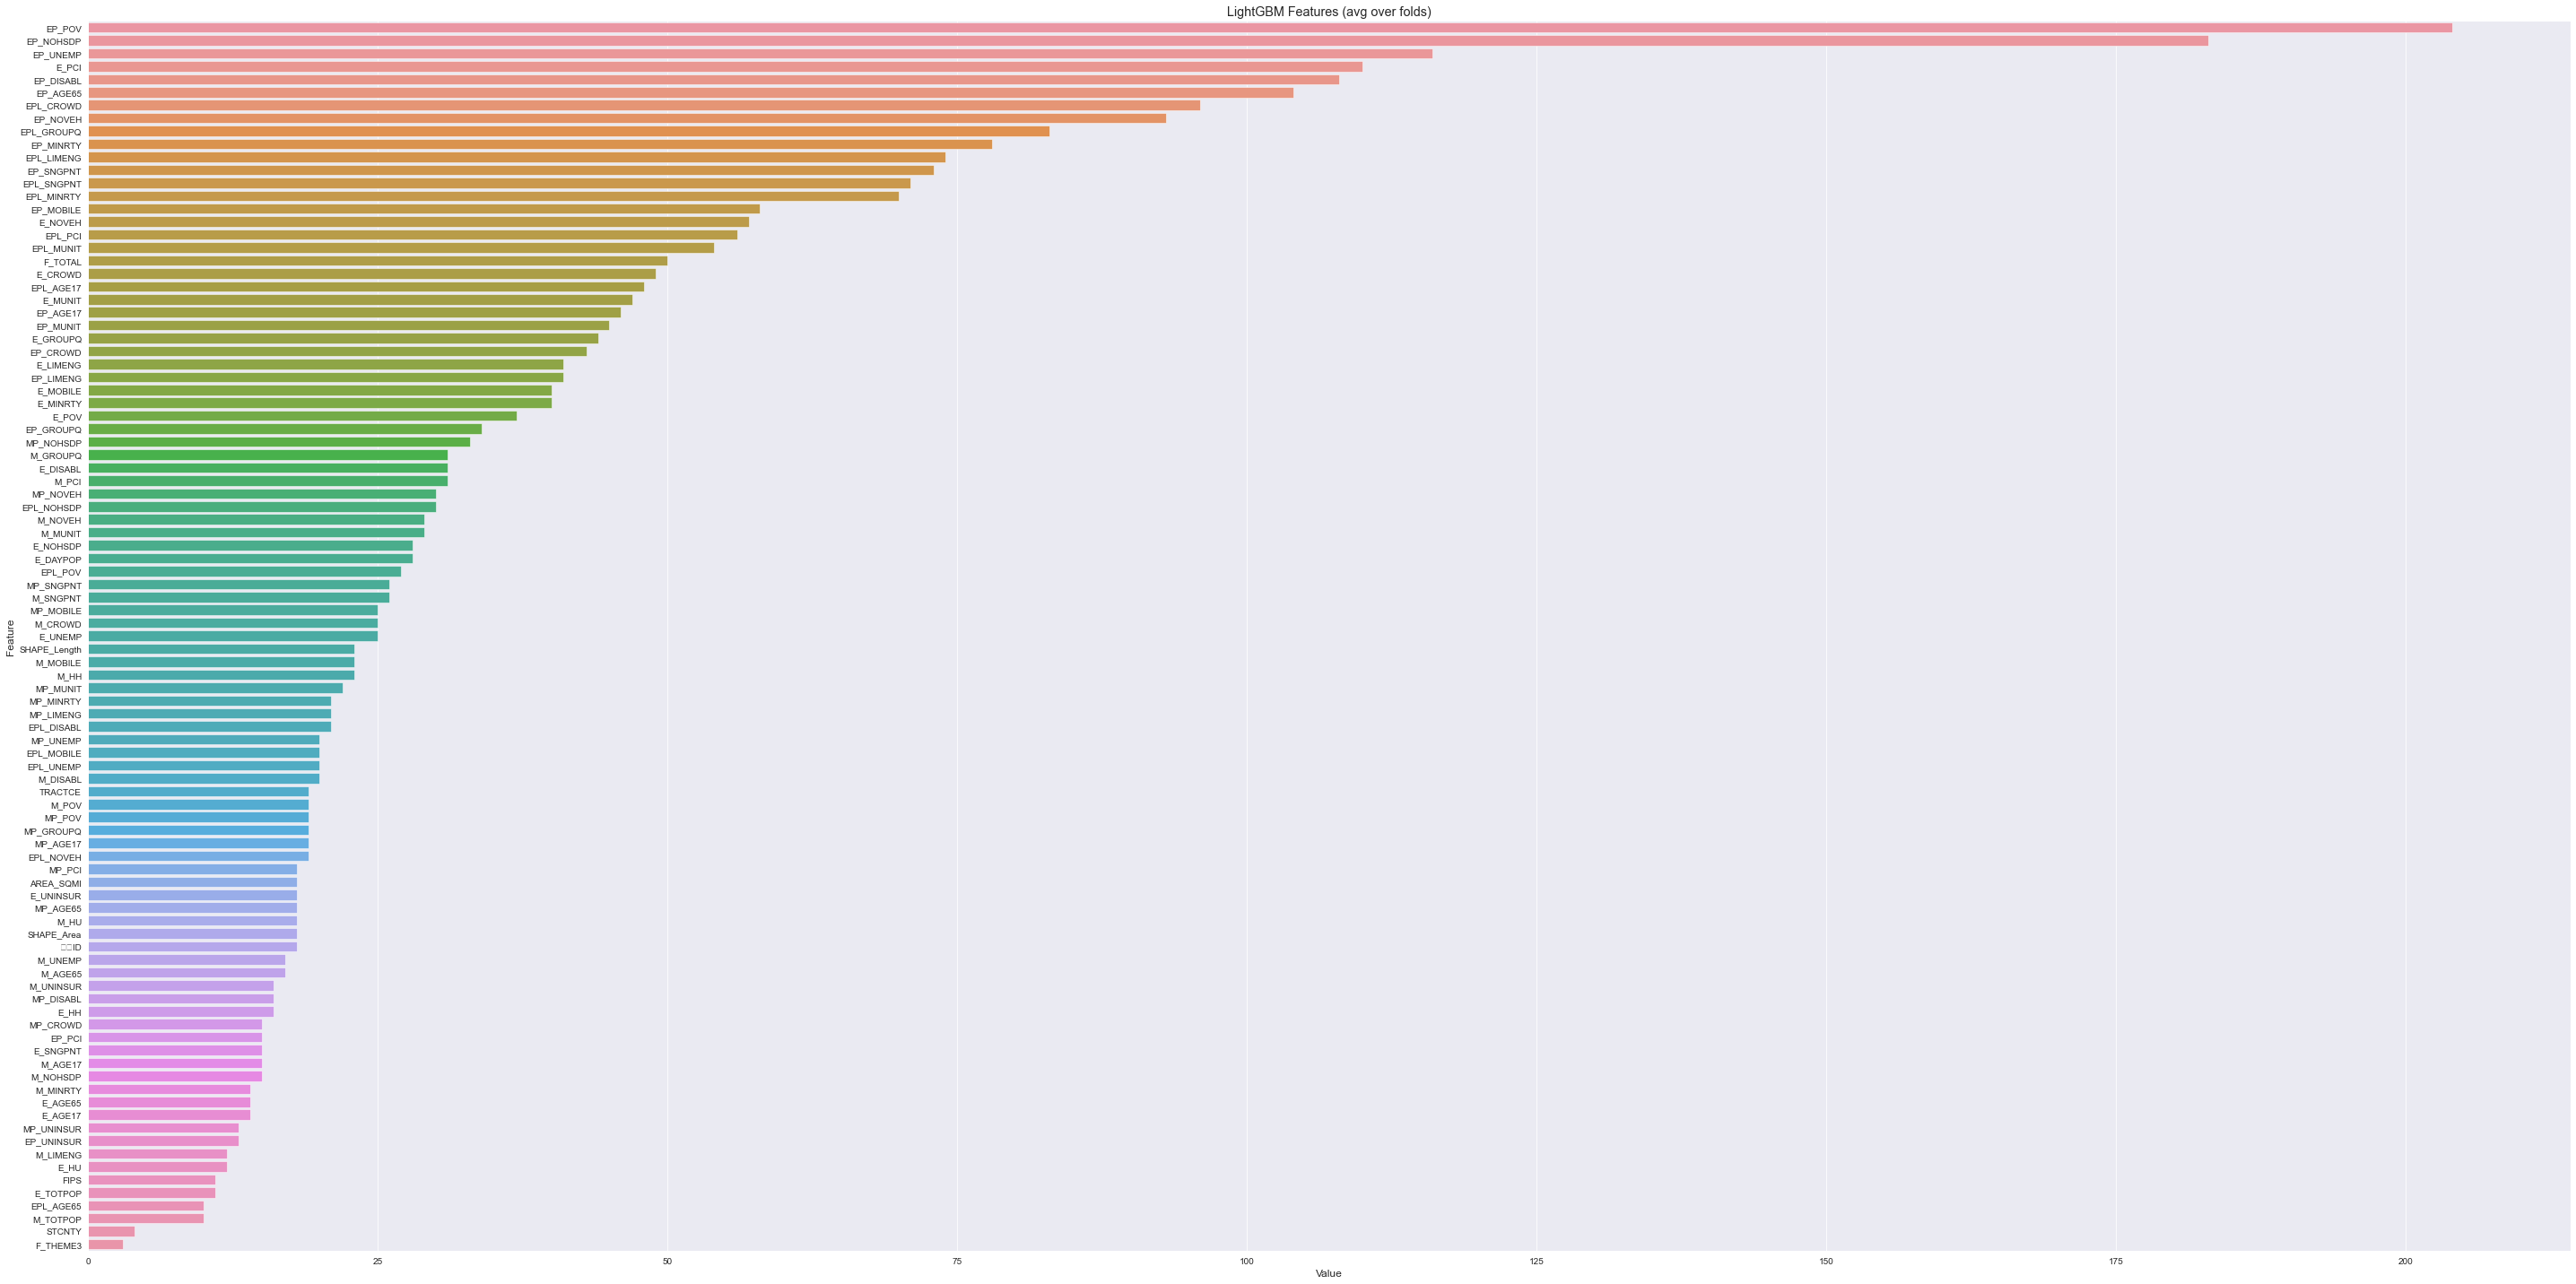

feature importance for RPL_THEMES


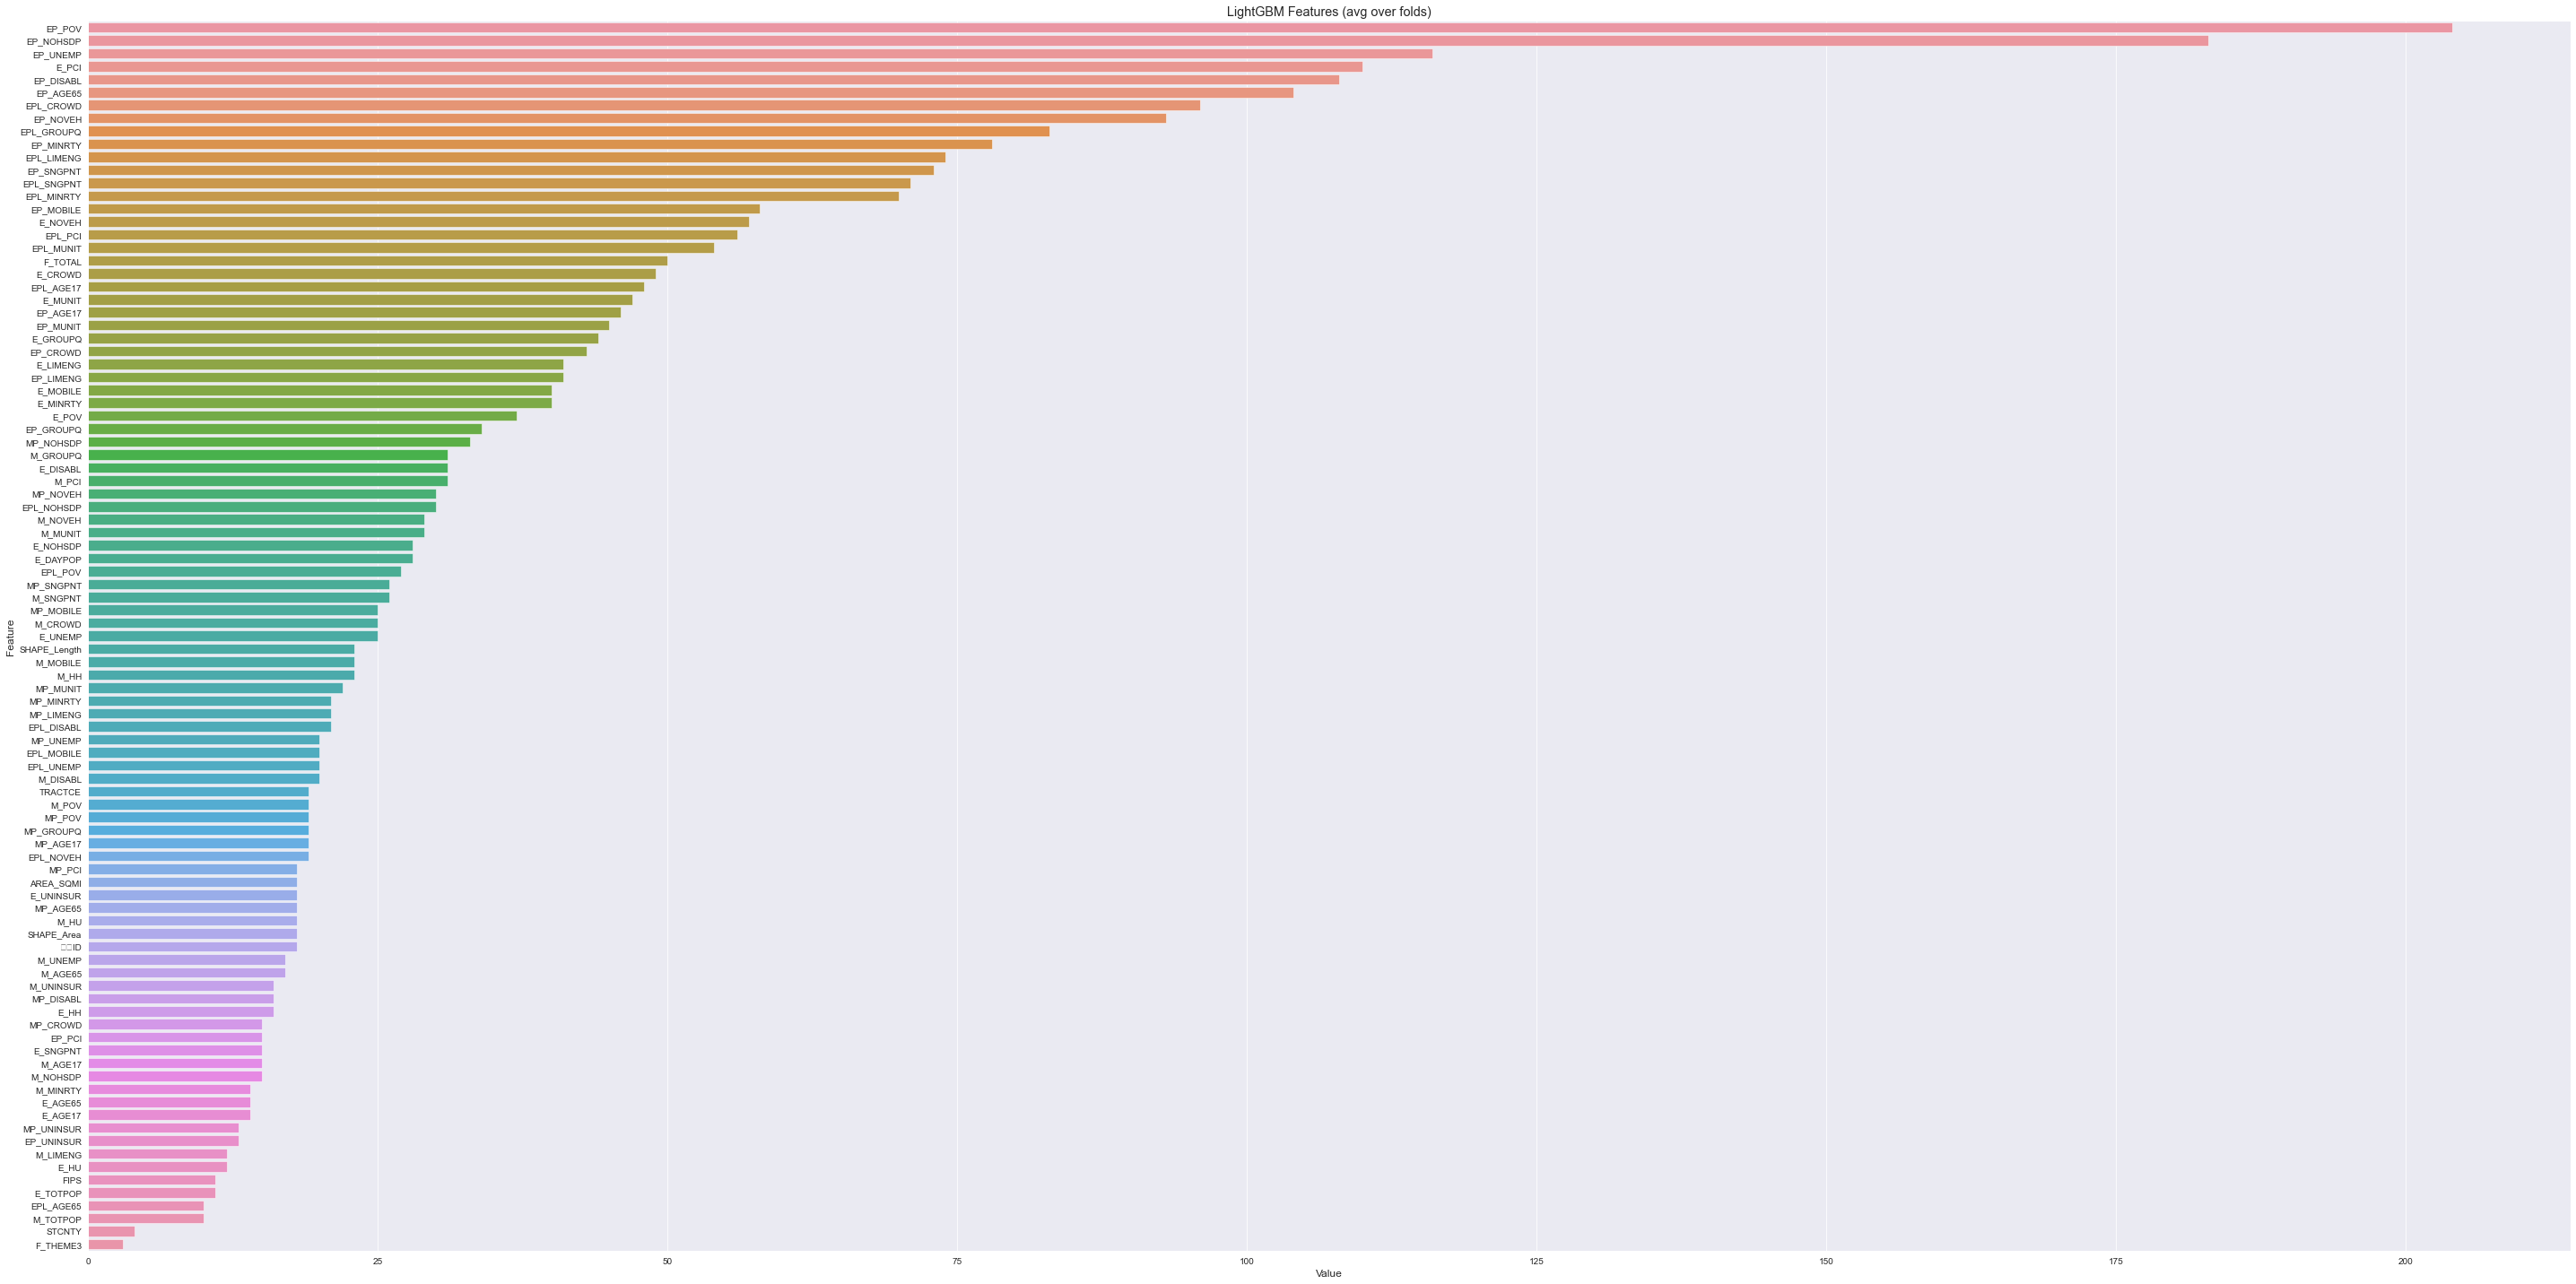

In [112]:
for i, plot in enumerate(plots):
    print('feature importance for', all_targets[i])
    plt.figure(figsize=(40, 20))
    sns.barplot(x="Value", y="Feature", data=plot.sort_values(by="Value", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.show()
    

## After the model found out the useless features (importance <= 1), we filter them out and use the new data to train the model 
## the result is comparable and saves more computation 

In [113]:
# %%capture
results_dict_v2 = []
for i, target in enumerate(all_targets):  
    data_label=selected_data[target].values
    data_inputs_i = data_inputs[all_useful_columns[i]]
    X_train,x_test,y_train,y_test = split_data[i]
    X_train = X_train[all_useful_columns[i]]
    x_test = x_test[all_useful_columns[i]]
#     X_train,x_test,y_train,y_test=train_test_split(data_inputs, data_label, test_size=0.2)
    
    model = lgb.LGBMRegressor(**param)    
    model.fit(X_train,y_train,eval_set=[(x_test,y_test)], early_stopping_rounds=100, verbose=False, )
    preds = model.predict(x_test)
    rmse = mean_squared_error(y_test, preds, squared=False)
    results_dict_v2.append([target, rmse])


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01
[LightGBM] [Warning] bagging_fraction is set=0.98, subsample=1.0 will be ignored. Current value: bagging_fraction=0.98
[LightGBM] [Warning] lambda_l1 is set=1e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1e-06
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bag

## Results without feature selection

In [114]:
for item in results_dict_v1:
    print('rmse scores for target ', item[0], ' is ', (item[1]*100.0).round(3), '%')

rmse scores for target  RPL_THEME1  is  1.641 %
rmse scores for target  RPL_THEME2  is  2.987 %
rmse scores for target  RPL_THEME3  is  0.715 %
rmse scores for target  RPL_THEME4  is  3.197 %
rmse scores for target  RPL_THEMES  is  4.355 %


## Results with feature selection(better precision)

In [115]:
for item in results_dict_v2:
    print('rmse scores for target ', item[0], ' is ', (item[1]*100.0).round(3), '%')

rmse scores for target  RPL_THEME1  is  1.745 %
rmse scores for target  RPL_THEME2  is  2.85 %
rmse scores for target  RPL_THEME3  is  0.763 %
rmse scores for target  RPL_THEME4  is  3.446 %
rmse scores for target  RPL_THEMES  is  4.336 %


# 4.3 Then we use the engineered data features by adding and subtracting the variable starting with M_ which is the error to its corresponding estimated variable starting with E_. Thus, we analyze with the maximum, estimated and minimum possible values of the variable. 

# The result shows greater precision than the previous two. 

In [116]:
%%capture
e_columns = []
for column in data.columns:
    if column.startswith('E'):
        e_columns.append(column)
               
engineered_data = data.copy()
for column in e_columns:
    if 'M_' + column.split('_')[1] in data.columns:
        engineered_data['max_'+column] = engineered_data[column] + engineered_data['M_' + column.split('_')[1]]
        engineered_data['min_'+column] = engineered_data[column] - engineered_data['M_' + column.split('_')[1]]
    elif 'MP_' + column.split('_')[1] in data.columns:
        engineered_data['max_'+column] = engineered_data[column] + engineered_data['MP_' + column.split('_')[1]]
        engineered_data['min_'+column] = engineered_data[column] - engineered_data['MP_' + column.split('_')[1]]
        
        
        
all_targets = ['RPL_THEME1', 'RPL_THEME2', 'RPL_THEME3', 'RPL_THEME4', 'RPL_THEMES']
all_targets_spl = ['SPL_THEME1', 'SPL_THEME2', 'SPL_THEME3', 'SPL_THEME4', 'SPL_THEMES']

param =   {
        'num_leaves': 50,
        'objective': 'rmse',  
        'max_depth': 10,
        'learning_rate': 3e-1,
        "boosting": "gbdt",
        'lambda_l1': 1e-6,
        'lambda_l2': 1e-2,
        'bagging_freq': 5,
        'bagging_fraction': 0.98,
        "feature_fraction": 0.8,
        "verbosity":-1,
    }
data_inputs=engineered_data.copy()
data_inputs.drop(columns=all_targets,inplace=True)
data_inputs.drop(columns=all_targets_spl,inplace=True)
all_feature_imp = []
results_dict_v3 = []
split_data = []
for target in all_targets:  
    data_label=engineered_data[target].values
    X_train,x_test,y_train,y_test=train_test_split(data_inputs, data_label, test_size=0.2)
    split_data.append([X_train,x_test,y_train,y_test])
    model = lgb.LGBMRegressor(**param)    
    model.fit(X_train,y_train,eval_set=[(x_test,y_test)], early_stopping_rounds=100, verbose=False, )
    preds = model.predict(x_test)
    rmse = mean_squared_error(y_test, preds, squared=False)
        
    all_feature_imp.append(model.feature_importances_)
    results_dict_v3.append([target, rmse])
    

In [117]:
for item in results_dict_v3:
    print('rmse scores for target ', item[0], ' is ', (item[1]*100.0).round(3), '%')

rmse scores for target  RPL_THEME1  is  1.177 %
rmse scores for target  RPL_THEME2  is  2.039 %
rmse scores for target  RPL_THEME3  is  0.462 %
rmse scores for target  RPL_THEME4  is  2.246 %
rmse scores for target  RPL_THEMES  is  2.955 %


In [118]:
%%capture
results_dict_v4 = []
for i, target in enumerate(all_targets):  
    data_label=engineered_data[target].values
    data_inputs_i = data_inputs[all_useful_columns[i]]
    X_train,x_test,y_train,y_test = split_data[i]
    X_train = X_train[all_useful_columns[i]]
    x_test = x_test[all_useful_columns[i]]
    
    model = lgb.LGBMRegressor(**param)    
    model.fit(X_train,y_train,eval_set=[(x_test,y_test)], early_stopping_rounds=100, verbose=False, )
    preds = model.predict(x_test)
    rmse = mean_squared_error(y_test, preds, squared=False)
    results_dict_v4.append([target, rmse])


In [119]:
for item in results_dict_v4:
    print('rmse scores for target ', item[0], ' is ', (item[1]*100.0).round(3), '%')

rmse scores for target  RPL_THEME1  is  1.157 %
rmse scores for target  RPL_THEME2  is  2.015 %
rmse scores for target  RPL_THEME3  is  0.677 %
rmse scores for target  RPL_THEME4  is  2.337 %
rmse scores for target  RPL_THEMES  is  2.885 %



# Final results

![Result_](result_.png)

## The baseline means the model without feature selecton or new features addition

## Featue selection means the model has features with low importance(<=1) filtered out 

## Features addition means the we add new features. Specifically, we add (1) estimated value to error to obtain maximum estimation and also (2) subtract error to estimated value to obtain minimum estimation

# 5. Analysis on important features

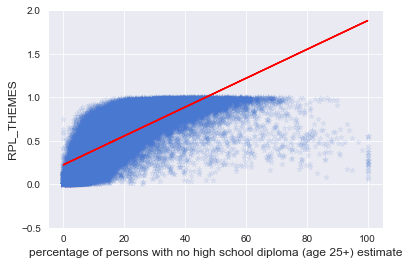

In [61]:
x=data.EP_POV
y=data.RPL_THEMES
m, b = np.polyfit(x, y, 1)
plt.scatter(x,y,alpha=0.1,marker='*')
plt.plot(x, m*x + b,color='r')
plt.ylim(-0.5,2)
plt.xlabel('percentage of persons with no high school diploma (age 25+) estimate')
plt.ylabel('RPL_THEMES')
plt.show()

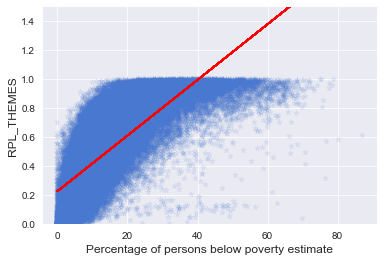

In [62]:
x=data.EP_NOHSDP
y=data.RPL_THEMES
m, b = np.polyfit(x, y, 1)
plt.scatter(x,y,alpha=0.1,marker='*')
plt.plot(x, m*x + b,color='r')
plt.ylim(0,1.5)
plt.xlabel('Percentage of persons below poverty estimate')
plt.ylabel('RPL_THEMES')
plt.show()

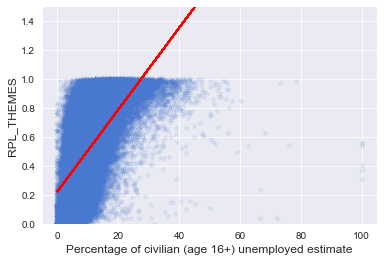

In [63]:
x=data.EP_UNEMP
y=data.RPL_THEMES
m, b = np.polyfit(x, y, 1)
plt.scatter(x,y,alpha=0.1,marker='*')
plt.plot(x, m*x + b,color='r')
plt.ylim(0,1.5)
plt.xlabel('Percentage of civilian (age 16+) unemployed estimate')
plt.ylabel('RPL_THEMES')
plt.show()

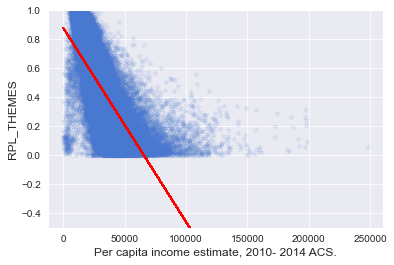

In [64]:
x=data.E_PCI
y=data.RPL_THEMES
m, b = np.polyfit(x, y, 1)
plt.scatter(x,y,alpha=0.1,marker='*')
plt.plot(x, m*x + b,color='r')
plt.ylim(-0.5,1)
plt.xlabel('Per capita income estimate, 2010- 2014 ACS.')
plt.ylabel('RPL_THEMES')
plt.show()